<a href="https://colab.research.google.com/github/eshghinezhad/ML_Classifire_Student_Success/blob/master/V2/Student_Success_Classifires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Assignment 2- Building Classifiers** ---------- **Monireh Eshghinezhad**
> #

In [31]:
import numpy as np
import pandas as pd

##  **Data Loading and Initial Cleaning** (Brief EDA)

In [32]:
student=pd.read_csv("MAI101 W26 A1 data v0.1.csv")

Base on the assignment1, the dataset contains 1,677 **rows** and 17 **columns**.
Several variables contain **missing** values.
The Business101Grade variable includes values **outside** the expected **range** (>100).
The status variable contains **invalid categories** ('S', 'X', 'V2'). Some column names contain spaces.

####Before proceeding with modeling, basic data cleaning was performed:

1.   Renamed columns to remove spaces.
2.   Kept only valid status values ('D', 'I').
3.   Removed records where Business101Grade exceeded 100.
4.   Reset the index after filtering.

## **Structural Fix:**

In [33]:
#assign the appropriate name for some features
student = student.rename(columns={
 "Math101 Grade": "Math101Grade",
 "Business101 Grade": "Business101Grade",
 "Overall Average Grade": "OverallAverageGrade"
})
# keeps only valid status.
valid_status = ['D', 'I']
student = student[student['status'].isin(valid_status)]
# keeps only valid Business101Grade
student = student[student['Business101Grade'] <= 100 ]
# creates a new index & Do not keep the old index as a separate column.
student = student.reset_index(drop=True)

## **Create the Target Variable**:
### Create the new column '**on_schedule**' (1 or 0) base on '**duration**' and '**totalSemesters**'

In [34]:
student['onSchedule'] = ((student.hasGraduated == 1) &
(student.totalSemesters <= (student.duration * 2 + 2))).astype(int)

## **Analyze Target Variable:**
 >##  **A- Class Balance**

In [35]:
# Show the number and proportion of each class in target variable.
print(student.onSchedule.value_counts())
print("-"*50)
print (student["onSchedule"].value_counts(normalize=True))   #show the percentage of each value

onSchedule
0    1037
1     618
Name: count, dtype: int64
--------------------------------------------------
onSchedule
0    0.626586
1    0.373414
Name: proportion, dtype: float64


### The target variable shows a **moderate class imbalance**. Approximately 63% of students did not graduate on schedule, while 37% graduated on schedule.
> ### Because of this imbalance, evaluation metrics beyond overall accuracy, such as **precision**, **recall**, and **F1-score**, will be considered to properly **assess model performance**.

>## **B- Class Relationships**

In [36]:
 # Show the relationship between the target variable and other features
display(pd.crosstab(student["gender"], student["onSchedule"]))
display(pd.crosstab(student["transfer_in"], student["onSchedule"]))
display(pd.crosstab(student["Mature"], student["onSchedule"]))

onSchedule,0,1
gender,,
F,366,249
M,671,369


onSchedule,0,1
transfer_in,,
0,734,329
1,303,289


onSchedule,0,1
Mature,,
0,541,235
1,496,383


> # **Feature and Target Separation**

In [37]:
numerical_features = ['LangTestPercent','MathTestPercent',
                      'AptitudeTestPercent', 'transfer_in', 'Business101Grade',
                      'Mature']
categorical_features = ['program','duration', 'status', 'gender', 'Math101Grade']

x = student[numerical_features + categorical_features]
y = student["onSchedule"]

## **Split dataset** into **Training(60%)**, **Validation(20%)** and **Test(20%)** sets
#####The data was split using a fixed random state for reproducibility and stratification to preserve the class distribution in both training and testing sets.

In [38]:
from sklearn.model_selection import train_test_split

# 1. Split into (Train + Val)(80%) and Test(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y
)

# 2. Split (Train + Val) into separate Train(60%) and Validation(20%) sets      stratify=y: keeps the class distribution consistent.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val
)

###  **Variable Issues & Steps Report**

| Variable Name    |	Issue Identified	       |  Step/Transformation Applied    |
|------------------|--------------------------|---------------------------------|
| onSchedule       | Not explicitly in dataset|Create the new column,using hasGraduated and totalSemesters columns.
| Numeric Features | Missing values, different scales|Imputed using median strategy, then standardized (Z-score scaling)|
|Categorical Features| Text values need numeric representation|One-Hot Encoding applied to convert categories to binary features|

####To prevent data leakage, all **imputation** and **scaling** parameters were derived exclusively from the training data (X_train and y_train) and then applied using a **ColumnTransformer** within the **pipelines**.
###Also applied stratification during the train, validation, and test split to maintain the class distribution ratio (63% / 37%) across all three sets.

> ## Build the **ColumnTransformer** and **Pipeline**
Apply different transformations to different columns.
| Column Type   | Transformation       |
|---------------|----------------------|
| Numeric       |  **Median** + **Scaling**    |
| Categorical   |  OneHotEncode        |

In [39]:
# we have mixed columns(numeric + categorical). we need apply different transformations to different columns.
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Define the pipelines for each type of feature
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Fills missing with median
    ('scaler', StandardScaler())                    # Scales the numericals for distance-based algorithms (KNN, SVM) is required.
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handles new categories in test set
])

# 2. Combine them into one ColumnTransformer
full_prep = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# **1- K-Nearest Neighbors Classifier**


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
# Builds a model structure.-> n_neighbors = 5 (default value)
baseline_knn = make_pipeline(full_prep, KNeighborsClassifier())
baseline_knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'duration',
                                                   'status', 'gender',
                                                   'Math101Grade'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

## **A- Train and Evaluate Performance**
> - ### **Evaluate Baseline Model**

In [41]:
# Baseline KNN (default parameters)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

baseline_knn = make_pipeline(full_prep, KNeighborsClassifier())

baseline_knn.fit(X_train, y_train)

y_val_pred_baseline = baseline_knn.predict(X_val)

print("BASELINE K Neighbors Model:")
print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred_baseline):.2f}")
print("Validation F1:", f"{f1_score(y_val, y_val_pred_baseline):.2f}")
print("\n Confusion Matrix: \n",confusion_matrix(y_val, y_val_pred_baseline))
print("\n Classification Report:\n", classification_report(y_val, y_val_pred_baseline, target_names=['0-not onSchedule', '1-onSchedule']))

BASELINE K Neighbors Model:
Validation Accuracy: 0.63
Validation F1: 0.48

 Confusion Matrix: 
 [[152  56]
 [ 67  56]]

 Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.69      0.73      0.71       208
    1-onSchedule       0.50      0.46      0.48       123

        accuracy                           0.63       331
       macro avg       0.60      0.59      0.59       331
    weighted avg       0.62      0.63      0.62       331



> - ## **Model Performance Report**
 ### The baseline KNN model exhibits a tendency to **misclassify the minority class** ('onSchedule'), leading to a significant number of **false negatives**. This highlights the **need for hyperparameter tuning** and potentially strategies to address class imbalance to improve the model's ability to correctly identify students on schedule.

  > - ### **Analize the model** - 4 difrent numbers of Neighbors

In [42]:
for k in [1, 15,25, 50]:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train)

    y_train_pred = knn_model.predict(X_train)
    y_validation_pred = knn_model.predict(X_val)

    print(f"k = {k}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
    print(f"Validation Accuracy : {accuracy_score(y_val, y_validation_pred):.2f}")
    print("-"*40)
    print(classification_report(y_val, y_validation_pred, target_names=['Class 0', 'Class 1']))
    print("=" * 50)

k = 1
Train Accuracy: 1.00
Validation Accuracy : 0.57
----------------------------------------
              precision    recall  f1-score   support

     Class 0       0.66      0.66      0.66       208
     Class 1       0.43      0.42      0.42       123

    accuracy                           0.57       331
   macro avg       0.54      0.54      0.54       331
weighted avg       0.57      0.57      0.57       331

k = 15
Train Accuracy: 0.73
Validation Accuracy : 0.68
----------------------------------------
              precision    recall  f1-score   support

     Class 0       0.72      0.80      0.76       208
     Class 1       0.58      0.47      0.52       123

    accuracy                           0.68       331
   macro avg       0.65      0.63      0.64       331
weighted avg       0.67      0.68      0.67       331

k = 25
Train Accuracy: 0.70
Validation Accuracy : 0.66
----------------------------------------
              precision    recall  f1-score   support

    

>  #### **Accuracy** alone would **mislead** toward majority class, **F1-score** is more **reliable** metric. Although accuracy slightly increased as k became larger, the F1-score for the **minority class** showed a **different trend**.

  > -  ### **Visuallize the trade-off between Bias and Variance**
    **Compare Accuracy** and **F1 Score**

Compare the accuracy between training and validation in each K


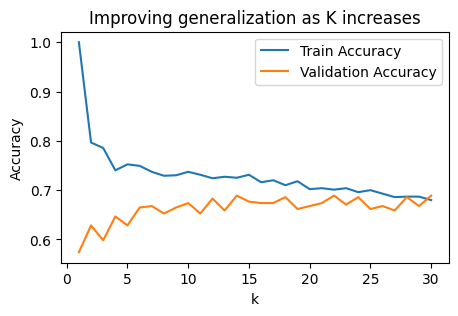

The number of neighbors (k) significantly affects model complexity
Increasing k generally improves generalization (reduces overfitting) up to a point


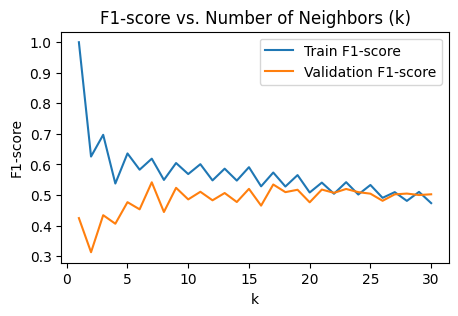

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

train_scores = []
Validation_scores = []
train_f1_scores = []
validation_f1_scores = []

k_values = range(1, 31)
for k in k_values:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train) #Train the model by training set

    # Make predictions
    y_train_pred = knn_model.predict(X_train)
    y_val_pred = knn_model.predict(X_val)

    # Calculate accuracy scores
    train_scores.append(accuracy_score(y_train, y_train_pred))
    Validation_scores.append(accuracy_score(y_val, y_val_pred))

    # Calculate F1 scores
    train_f1_scores.append(f1_score(y_train, y_train_pred))
    validation_f1_scores.append(f1_score(y_val, y_val_pred))
print ('Compare the accuracy between training and validation in each K')
plt.figure(figsize=(5,3 ))
plt.plot(k_values, train_scores, label="Train Accuracy")
plt.plot(k_values,Validation_scores, label="Validation Accuracy")
plt.title('Improving generalization as K increases')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print ('The number of neighbors (k) significantly affects model complexity')
print('Increasing k generally improves generalization (reduces overfitting) up to a point')
plt.figure(figsize=(5,3 ))
plt.plot(k_values, train_f1_scores, label="Train F1-score")
plt.plot(k_values, validation_f1_scores, label="Validation F1-score")
plt.title("F1-score vs. Number of Neighbors (k)")
plt.xlabel("k")
plt.ylabel("F1-score")
plt.legend()
plt.show()

>#### For **small k** values, the model **overfits**, achieving perfect or near-perfect training accuracy but significantly lower validation performance.
>#### As **k increases**, training and validation performance converge, indicating **improved generalization**.
>#### **Moderate k** values provide the **best balance** between bias and variance.


---



# **B- Tune Hyperparameter** :  
> - ## **GridSearchCV** for kNN (Tune n_neighbors and weights)

In [44]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 31)),
    'kneighborsclassifier__weights': ['uniform', 'distance']
}
# Use GridSearchCV to find the best parameter 'k' using the training data
grid_knn = GridSearchCV(knn_model, param_grid, cv=5, scoring='f1', n_jobs=-1) # Use F1 score because of the slight class imbalance

grid_knn.fit(X_train, y_train)

print("Best parameters found: \n", grid_knn.best_params_)  # The specific combination of hyperparameters that achieved the highest F1 score.
print(f"\nBest cross-validation F1 score: {grid_knn.best_score_:.2f}")  # The mean cross-validated score (F1) of the best parameter set.

best_knn = grid_knn.best_estimator_

Best parameters found: 
 {'kneighborsclassifier__n_neighbors': 11, 'kneighborsclassifier__weights': 'uniform'}

Best cross-validation F1 score: 0.52


> - ## **Evaluate Tuned K-Nearest Neighbors Model**

In [45]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_val_pred_tuned_knn = best_knn.predict(X_val)

print("TUNED KNN Model Performance on Validation Set")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_tuned_knn):.2f}")
print(f"Validation F1: {f1_score(y_val, y_val_pred_tuned_knn):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_tuned_knn))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_tuned_knn, target_names=['0-not onSchedule', '1-onSchedule']))

TUNED KNN Model Performance on Validation Set
Validation Accuracy: 0.65
Validation F1: 0.51

Confusion Matrix:
 [[156  52]
 [ 63  60]]

Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.71      0.75      0.73       208
    1-onSchedule       0.54      0.49      0.51       123

        accuracy                           0.65       331
       macro avg       0.62      0.62      0.62       331
    weighted avg       0.65      0.65      0.65       331



> - ## **Measuring F1 Improvement**

In [46]:
from sklearn.metrics import f1_score

knn_base_f1 = f1_score(y_val, y_val_pred_baseline)
knn_tuned_f1 = f1_score(y_val, y_val_pred_tuned_knn)

print(f"Baseline KNN F1: {knn_base_f1:.2f}")
print(f"Tuned KNN F1   : {knn_tuned_f1:.2f}")
print(f"improvement: {(knn_tuned_f1 - knn_base_f1):.2f}")

Baseline KNN F1: 0.48
Tuned KNN F1   : 0.51
improvement: 0.03


> - ## **Tuned K-Nearest Neighbors Model Performance Report**
####GridSearchCV identified an optimal neighborhood size that improved minority-class F1-score
#### Hyperparameter tuning for the KNN model led to a **modest improvement** in overall accuracy and F1-score for the minority class. The model shows a better balance in precision and recall, but addressing the false negatives for the 'onSchedule' class remains a key area for further optimization.

# **2- Logistic Regression Model**

In [47]:
from sklearn.linear_model import LogisticRegression

baseline_logReg = Pipeline([
    ("prep", full_prep),                                    #liblinear: supports L1 (Lasso) regularization, which automatically perform feature selection.
    ("LogRegClf", LogisticRegression( solver="liblinear"))  # stable for small/medium data
])

baseline_logReg


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'duration',
                                                   'status', 'gender',
                                                   'Math101Grade'])])),
                ('LogRegClf', LogisticRegression(solver='liblinear'))])

## **A- Train and Evaluate Performance**
> - ### **Evaluate Baseline Model**

In [48]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

baseline_logReg.fit(X_train, y_train)   #Train the model

y_val_pred = baseline_logReg.predict(X_val)

print("Baseline Logistic Regression Model")
print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred):.2f}")
print("Validation F1      :", f"{f1_score(y_val, y_val_pred):.2f}") # F1 = harmonic mean of precision and recall.
print("\nConfusion matrix:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['0-not onSchedule', '1-onSchedule']))


Baseline Logistic Regression Model
Validation Accuracy: 0.64
Validation F1      : 0.49

Confusion matrix:
 [[156  52]
 [ 66  57]]
                  precision    recall  f1-score   support

0-not onSchedule       0.70      0.75      0.73       208
    1-onSchedule       0.52      0.46      0.49       123

        accuracy                           0.64       331
       macro avg       0.61      0.61      0.61       331
    weighted avg       0.64      0.64      0.64       331



> - ## **Model Performance Report**
####F1-score for class 1 (onSchedule) is the primary metric, Because classes are imbalanced.
#### recall for class 1 is low -> The **model tends to favor the majority class**(0). The model currently shows a **bias** toward the **majority class** ('not onSchedule'). Because the dataset is imbalanced, the model has learned the characteristics of class 0 more effectively than class 1, leading to a **high rate of False Negatives** for the 'onSchedule' category
####To **fix** this "Recall" **Problem**,  I add **class_weight='balanced'** inside LogisticRegression parameters (in GridSearch) -> This will tell the model to pay **more attention** to the **minority class**.

# **B- Hyperparameter tuning**  using GridSearchCV

In [49]:
logReg_model = Pipeline([
    ("prep", full_prep),
    ("LogRegClf", LogisticRegression( max_iter=2000, solver="liblinear")) #2000:Maximum number of iterations allowed for convergence
])
param_grid = {
    "LogRegClf__C": np.logspace(-3, 3, 13),       # 0.001 ... 1000  controls model complexity
    "LogRegClf__penalty": ["l1", "l2"],           # Type of regularization
    "LogRegClf__class_weight": [None, "balanced"] # adjusts the importance of minority-class errors
}

cv = StratifiedKFold(n_splits=5, shuffle=True) # preserve class proportions across folds

grid_logReg = GridSearchCV(
    logReg_model, param_grid=param_grid, scoring="f1", cv=cv, n_jobs=-1)

grid_logReg.fit(X_train, y_train)

print("Best params found:\n", grid_logReg.best_params_)
print(f"Best cross-validation F1 score:: {grid_logReg.best_score_:.2f}")

best_logReg = grid_logReg.best_estimator_


Best params found:
 {'LogRegClf__C': np.float64(0.001), 'LogRegClf__class_weight': 'balanced', 'LogRegClf__penalty': 'l2'}
Best cross-validation F1 score:: 0.62


> - ## **Evaluate Tuned  Logistic Regression Model**

In [50]:
y_val_pred_tuned_logReg = best_logReg.predict(X_val)

print("TUNED Logistic Regression Model Performance on Validation Set")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_tuned_logReg):.2f}")
print(f"Validation F1: {f1_score(y_val, y_val_pred_tuned_logReg):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_tuned_logReg))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_tuned_logReg,
                                  target_names=['0-not onSchedule', '1-onSchedule']))

TUNED Logistic Regression Model Performance on Validation Set
Validation Accuracy: 0.60
Validation F1: 0.57

Confusion Matrix:
 [[107 101]
 [ 33  90]]

Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.76      0.51      0.61       208
    1-onSchedule       0.47      0.73      0.57       123

        accuracy                           0.60       331
       macro avg       0.62      0.62      0.59       331
    weighted avg       0.66      0.60      0.60       331



> - ## **Measuring F1 Improvement**

In [51]:
# Show “before vs after” improvement
from sklearn.metrics import f1_score

logreg_base_f1 = f1_score(y_val, y_val_pred)
logreg_tuned_f1 = f1_score(y_val, y_val_pred_tuned_logReg)

print(f"Baseline Logistic Regression F1: {logreg_base_f1:.2f}")
print(f"Tuned Logistic Regression F1   : {logreg_tuned_f1:.2f}")
print(f"improvement: {(logreg_tuned_f1 - logreg_base_f1):.2f}")

Baseline Logistic Regression F1: 0.49
Tuned Logistic Regression F1   : 0.57
improvement: 0.08


> - ## **Tuned Logistic Regression Model Performance Report**
#### The hyperparameter tuning, especially with class_weight='balanced', **successfully addressed** the baseline Logistic Regression model's **bias** towards the **majority class**. It significantly improved the model's ability to identify the minority class ('onSchedule'), leading to a **higher F1-score** and substantially **fewer false negatives**. While this resulted in more false positives, the overall performance for the critical 'onSchedule' class is much stronger, making this a more effective model for predicting students on schedule.


# **3- SVN Model**

In [52]:
from sklearn.svm import SVC

baseline_svm = Pipeline([
    ("prep", full_prep),
    ("SVM", SVC())   # defaults: kernel='rbf', C=1.0, gamma='scale'
])
baseline_svm

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'duration',
                                                   'status', 'gender',
                                                   'Math101Grade'])])),
                ('SVM', SVC())])

## **A- Train and Evaluate Performance**
> - ### **Evaluate Baseline Model**

In [53]:
baseline_svm.fit(X_train, y_train)

y_val_pred_svm_base = baseline_svm.predict(X_val)

print("Baseline SVM Model")
print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred_svm_base):.2f}")
print("Validation F1      :", f"{f1_score(y_val, y_val_pred_svm_base):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_svm_base))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_svm_base,
                                    target_names=["0-not onSchedule", "1-onSchedule"]
))

Baseline SVM Model
Validation Accuracy: 0.66
Validation F1      : 0.48

Confusion Matrix:
 [[165  43]
 [ 70  53]]

Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.70      0.79      0.74       208
    1-onSchedule       0.55      0.43      0.48       123

        accuracy                           0.66       331
       macro avg       0.63      0.61      0.61       331
    weighted avg       0.65      0.66      0.65       331



### **Model Performance Report**
#### The baseline SVM model, with its **default parameters**, shows **limited effectiveness** in predicting the 'onSchedule' class, evidenced by its **low F1-score** and high number of false negatives. This performance highlights a **strong need for hyperparameter tuning**, and potentially strategies to address class imbalance, to improve the model's ability to accurately identify students who are on schedule.

# **B- Hyperparameter tuning**  using GridSearchCV

In [66]:
svm_pipe = Pipeline([
    ("prep", full_prep),
    ("SVM", SVC(probability=True))
])

param_grid = [
    # Linear SVM
    {
        "SVM__kernel": ["linear"],
        "SVM__C": np.logspace(-2, 2, 9),
        "SVM__class_weight": [None, "balanced"]
    },
     # RBF SVM
    {
        "SVM__kernel": ["rbf"],
        "SVM__C": np.logspace(-2, 2, 9),
        "SVM__gamma": ["scale", "auto"],
        "SVM__class_weight": [None, "balanced"]
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True)

grid_svm = GridSearchCV(
    svm_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)
grid_svm.fit(X_train, y_train)

print("Best params:\n", grid_svm.best_params_)
print(f"Best CV F1 : {grid_svm.best_score_:.2f}")

best_svm = grid_svm.best_estimator_

Best params:
 {'SVM__C': np.float64(0.03162277660168379), 'SVM__class_weight': 'balanced', 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best CV F1 : 0.62


> - ## **Evaluate Tuned SVM Model**

In [67]:
y_val_pred_svm_tuned = best_svm.predict(X_val)

print("Tuned SVM (after tuning)")
print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred_svm_tuned):.2f}")
print("Validation F1      :", f"{f1_score(y_val, y_val_pred_svm_tuned):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_svm_tuned))
print("\nClassification Report:\n", classification_report( y_val, y_val_pred_svm_tuned,
                                    target_names=["0-not onSchedule", "1-onSchedule"]
))

Tuned SVM (after tuning)
Validation Accuracy: 0.60
Validation F1      : 0.61

Confusion Matrix:
 [[ 96 112]
 [ 20 103]]

Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.83      0.46      0.59       208
    1-onSchedule       0.48      0.84      0.61       123

        accuracy                           0.60       331
       macro avg       0.65      0.65      0.60       331
    weighted avg       0.70      0.60      0.60       331



> - ## **Measuring F1 Improvement**

In [68]:
# Show “before vs after” improvement clearly
base_f1 = f1_score(y_val, y_val_pred_svm_base)
tuned_f1 = f1_score(y_val, y_val_pred_svm_tuned)

print(f"Baseline SVM F1: {base_f1:.2f}")
print(f"Tuned SVM F1   : {tuned_f1:.2f}")
print(f"improvement: {(tuned_f1 - base_f1):.2f}")

Baseline SVM F1: 0.48
Tuned SVM F1   : 0.61
improvement: 0.13


> - ## **Tuned SVM Model Performance Report**
### The hyperparameter tuning with **class_weight='balanced'** for the SVM model was **highly effective**. It successfully addressed the baseline model's poor performance on the minority class, leading to a substantial **increase in F1-score** and significantly **fewer false negatives**. Despite an increase in false positives, the tuned SVM model is a much **more robust** and effective classifier for identifying students who are on schedule, demonstrating strong recall for the minority class.

# **Final Comparison**
> ## Evaluate the tuned models on the test set

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# retrain best models on train+val (80%)
best_knn.fit(X_train_val, y_train_val)
best_logReg.fit(X_train_val, y_train_val)
best_svm.fit(X_train_val, y_train_val)

models = {
    "KNN": best_knn,
    "LogReg": best_logReg,
    "SVM": best_svm
}
results = []
for name, model in models.items():
    pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred),
    })

results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1
2,SVM,0.658610,0.528796,0.814516,0.641270
1,LogReg,0.673716,0.547059,0.750000,0.632653
0,KNN,0.676737,0.580952,0.491935,0.532751


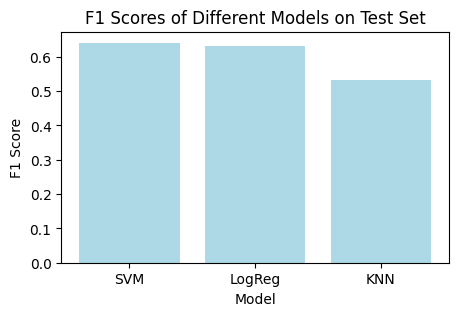

In [70]:
import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(5, 3))
plt.bar(results_df['Model'], results_df['F1'], color=['lightblue'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Different Models on Test Set')

# Display the plot
plt.show()


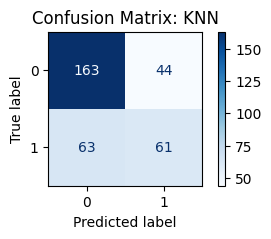

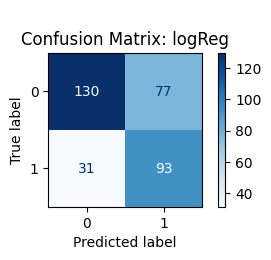

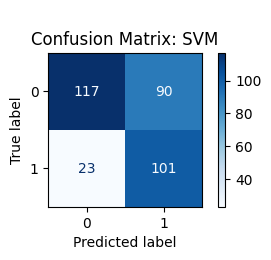

In [71]:
#Final Evaluation on Test Set
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# KNN Confusion Matrix
fig_knn, ax_knn = plt.subplots(figsize=(4, 2))
ConfusionMatrixDisplay.from_estimator(best_knn, X_test, y_test, cmap='Blues', ax=ax_knn)
ax_knn.set_title('Confusion Matrix: KNN')
plt.show()

# Logistic Regression Confusion Matrix
fig_logreg, ax_logreg = plt.subplots(figsize=(4, 2))
ConfusionMatrixDisplay.from_estimator(best_logReg, X_test, y_test, cmap='Blues', ax=ax_logreg)
ax_logreg.set_title('\nConfusion Matrix: logReg')
plt.show()

# SVM Confusion Matrix
fig_svm, ax_svm = plt.subplots(figsize=(4, 2))
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap='Blues', ax=ax_svm)
ax_svm.set_title('\nConfusion Matrix: SVM')
plt.show()

SVM Test ROC-AUC: 0.75


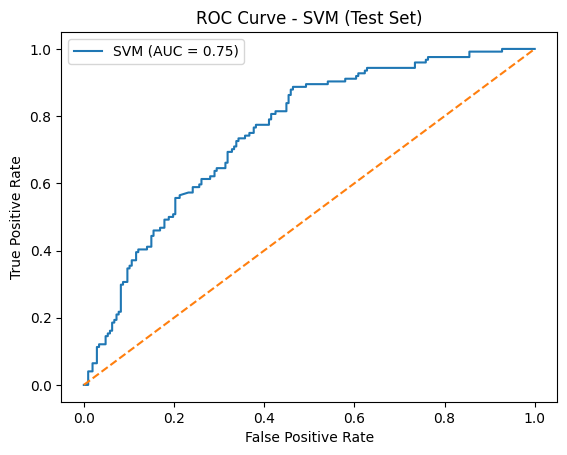

Logistic Regression ROC-AUC: 0.76


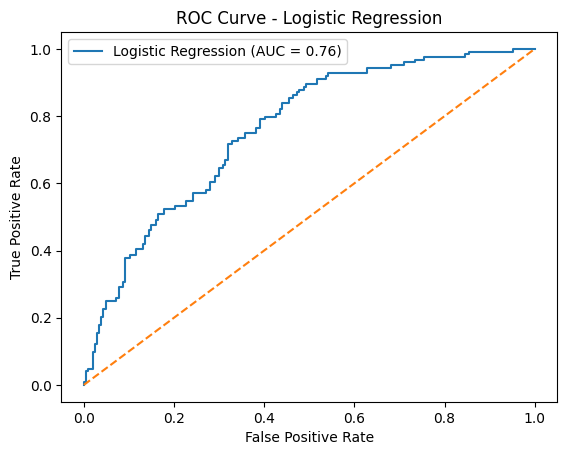

K-Nearest Neighbors ROC-AUC: 0.71


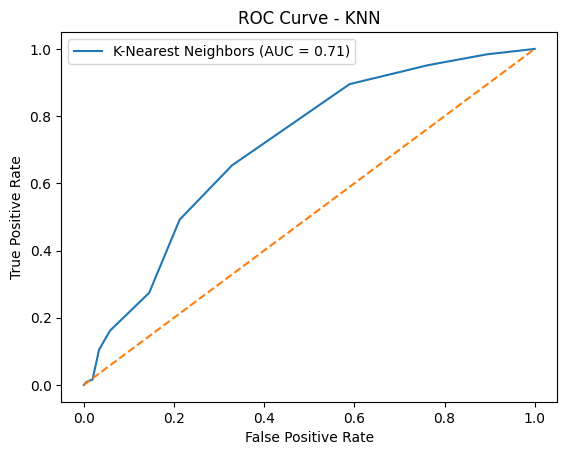

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score
y_test_prob_svm = best_svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_prob_svm)
auc_svm = roc_auc_score(y_test, y_test_prob_svm)

print("SVM Test ROC-AUC:", f"{auc_svm:.2f}")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM (Test Set)")
plt.legend()
plt.show()
#-------------
y_test_prob_logReg= best_logReg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_logReg)
auc = roc_auc_score(y_test, y_test_prob_logReg)

print("Logistic Regression ROC-AUC:", f"{auc:.2f}")
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")   # baseline: random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()
#--------------
y_test_prob_knn= best_knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob_knn)
auc = roc_auc_score(y_test, y_test_prob_knn)

print("K-Nearest Neighbors ROC-AUC:", f"{auc:.2f}")
plt.plot(fpr, tpr, label=f"K-Nearest Neighbors (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")   # baseline: random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN")
plt.legend()
plt.show()

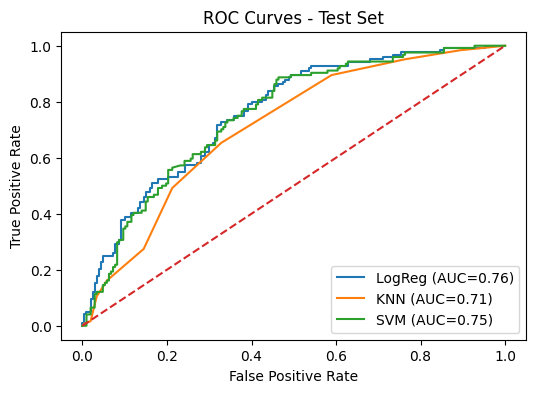

In [73]:
plt.figure(figsize=(6, 4))

# Logistic Regression
y_prob_log = best_logReg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC={auc_log:.2f})")

# KNN
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
auc_knn = roc_auc_score(y_test, y_prob_knn)
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC={auc_knn:.2f})")

# SVM
y_prob_svm = best_svm.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
auc_svm = roc_auc_score(y_test, y_prob_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={auc_svm:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend()
plt.show()

> - # **Best Model Identification**
> ### Model selection is based primarily on test **F1-score for class 1** due to **class imbalance**.
Based on the F1-score on the test set, the **Support Vector Machine (SVM) model** emerged as the best performing classifier with higher F1-score.

#### The evaluation and selection process revealed that addressing class imbalance thr/ough hyperparameter tuning, specifically using `class_weight='balanced'`, was crucial for improving the performance of Logistic Regression and SVM models. The **Support Vector Machine (SVM)** model, with its optimized hyperparameters, provided the **best F1-score** on the test set, indicating it is the most effective model for predicting students who are on schedule. While it had a slightly lower overall accuracy than KNN, its superior F1-score and better balance between precision and recall for the minority class make it the preferred choice for this classification task.